In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
# This package helps to download files from google drive
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#utility functions

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [4]:
# download the image file from shared link on google drive
import gdown
#url = 'https://drive.google.com/uc?id=1o25MqsrYRyMDOQLOororNncEC3KMziqp'
url='https://drive.google.com/uc?id=1sSRLTmRcU_rlM2yFz2zLyDcATtojeHID'
#url='https://drive.google.com/uc?id=1frpq1lnyIEzSntbyGcjg4-7b4c0c59md'
output = 'Toys.jpg'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1sSRLTmRcU_rlM2yFz2zLyDcATtojeHID
To: /content/Toys.jpg
100%|██████████| 264k/264k [00:00<00:00, 68.8MB/s]


'Toys.jpg'

(2992, 2992, 3)


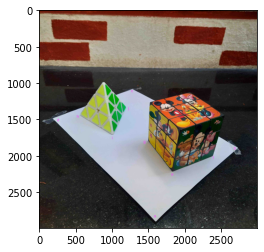

In [5]:
img = cv.cvtColor(cv.imread('Toys.jpg'), cv.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)

In [6]:
## Image feature points are identified using https://pixspy.com


a = [1598,2907,1]
b = [2728,1890,1]
c = [1283,1084,1]
d = [190,1489,1]
e = [1832,2215,1]
f = [2385,2000,1]
g = [1499,1790,1]
h = [564,1440,1]
i = [1012,1706,1]
j = [1197,1337,1]


In [7]:

#   Determining the vanishing points and the vanishing line to construct the 
#   matrix H_up which will remove the projective distortion

lab = np.cross(a,b)
ldc = np.cross(d,c)
lad = np.cross(a,d)
lbc = np.cross(b,c)

#the points at which the line at infinity passes
p1 = np.cross(lab,ldc)
p2 = np.cross(lad,lbc)

#the vanishing line
l12 = np.cross(p1,p2)
l12 = l12/l12[2]

print("The vanishing line is:",l12)

# Constructing the matrix H_up for undoing projectivity
H_up = np.eye(3)
H_up[2][0] = l12[0]
H_up[2][1] = l12[1]
print("\nH_up matrix is\n")
print(H_up)


#checking if it maps vanishing line to line at infinity
print("\nH_up maps the vanishing line to:",np.linalg.inv(H_up).T @ l12)

The vanishing line is: [-7.99876198e-05  1.48412472e-03  1.00000000e+00]

H_up matrix is

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-7.99876198e-05  1.48412472e-03  1.00000000e+00]]

H_up maps the vanishing line to: [0. 0. 1.]


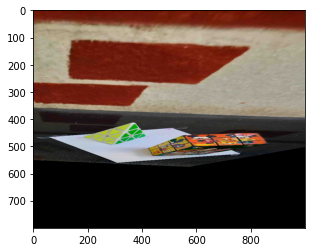

In [8]:
img_up = cv.warpPerspective(img,H_up,dsize=(1000,800))
plt.imshow(img_up)

In [9]:
#  Now removing the affine distortion by finding two pairs of orthogonal lines
#  and calculating the affine matrix


a_1 = H_up @ a
b_1 = H_up @ b
d_1 = H_up @ d
c_1 = H_up @ c

# finding two sets of perpendicular lines 
l1 = np.cross(a_1,b_1)
m1 = np.cross(a_1,d_1)
l2 = np.cross(d_1,c_1)
m2 = np.cross(c_1,b_1)

row1 = np.array([ l1[0]*m1[0], l1[0]+m1[1] + l1[1]+m1[0]])
row2 = np.array([ l2[0]*m2[0], l2[0]+m2[1] + l2[1]+m2[0]])
aa = np.stack((row1, row2),axis=0)
bb = np.array([l1[1]*m1[1], l2[1]*m2[1]])
x_sol = np.linalg.solve(aa,bb.T)
H_ua1 = np.array([[x_sol[0],x_sol[1]],[x_sol[1],1]])
print(H_ua1)

[[-3.5512852e+01 -4.9363103e-12]
 [-4.9363103e-12  1.0000000e+00]]


In [10]:
# Finding SVD to find the squareroot of K matrix where K = H_ua1 in this case

U, s, V = np.linalg.svd(H_ua1)
sv = np.zeros([2,2])
np.fill_diagonal(sv, np.sqrt(s),wrap=False)
A = np.dot(U,sv)
A = np.dot(A,U.T)
H_ua = np.eye(3)
H_ua[:2,:2] = A
H_ua = np.linalg.inv(H_ua)
print(H_ua)

[[ 1.67805899e-01 -1.12507462e-13  0.00000000e+00]
 [-1.12507462e-13  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


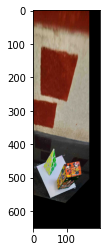

In [11]:
# Doing affine rectification
img_2 = cv.warpPerspective(img_up,H_ua ,dsize=(200,650))
plt.imshow(img_2)

In [12]:
# defining functions to get the angle and length
def angle(v1,v2):
  v1 = v1/v1[2]
  v2 = v2/v2[2]
  cos_theta = ( v1[0]*v2[0] + v1[1]*v2[1] )/ (  math.sqrt(v1[0]**2 + v1[1]**2) * math.sqrt(v2[0]**2 + v2[1]**2) )
  return math.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))

def len(x1,y1):
  A4_breadth = 29.6 # breadth of A4 sheet in cm
  a1 = H_ud @ a
  d1 = H_ud @ d
  x1=x1/x1[2]
  y1=y1/y1[2]
  a1=a1/a1[2]
  d1=d1/d1[2]
  return (math.dist(x1,y1)/math.dist(a1,d1))*A4_breadth

In [13]:
# Measuring the angles and lenghts
# Since the image is left only with similarity transform
# angles and ratios of lenghts are preserved between the original
# plan of the paper and the image of the paper.

#mapping all the points till affine transformation
H_ud = H_ua @ H_up

a1 = H_ud @ a
b1 = H_ud @ b
c1 = H_ud @ c
d1 = H_ud @ d
e1 = H_ud @ e
f1 = H_ud @ f
g1 = H_ud @ g
h1 = H_ud @ h
i1 = H_ud @ i
j1 = H_ud @ j

print("Angle of paper @ vertex a =",
      angle(np.cross(a1,b1), np.cross(a1,d1)) ,
      " degrees")


print("Angle  of tetrahedron face @ vertex i =",
      180 - angle( np.cross(i1,j1), np.cross(i1,h1)) ,
      " degrees")
print("Length of tetrahedron=",
      len(i1,h1),
      "cm")

print("Angle of cube face @ vertex e =",
      angle(np.cross(e1,f1), np.cross(e1,g1)) ,
      " degrees")

print("Length of Cube=",len(g1,e1),"cm")

Angle of paper @ vertex a = 90.0000000000302  degrees
Angle  of tetrahedron face @ vertex i = 65.84881679190069  degrees
Length of tetrahedron= 9.794086491613047 cm
Angle of cube face @ vertex e = 86.39679557851574  degrees
Length of Cube= 8.307072179236819 cm
